### Digital Forensics and Biometry - Audio Spoofing Detection

## This notebook contains Machine Learning part for dataset with Mel Frequency Cepstrum Coefficients
Made by: <br> Hubert Golasa - 2141831 <br> Andrea Signori - 2131195

Data was obtained from ASVspoof2019 dataset, training dataset. Firstly, I will import all libraries that will be used

In [10]:
!pip install xgboost

def get_files():
  files = ["MFCC_TRAIN_FEATURES_LABELED.csv"]
  repository_url = "https://github.com/vjescy/Audio-Spoofing-Detection/blob/main/"
  for file in files:
    ! wget -O {file} {repository_url}{file}


get_files()

--2025-02-03 18:31:35--  https://github.com/vjescy/Audio-Spoofing-Detection/blob/main/MFCC_TRAIN_FEATURES_LABELED.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘MFCC_TRAIN_FEATURES_LABELED.csv’

MFCC_TRAIN_FEATURES     [ <=>                ] 221.47K  --.-KB/s    in 0.1s    

2025-02-03 18:31:36 (1.85 MB/s) - ‘MFCC_TRAIN_FEATURES_LABELED.csv’ saved [226786]



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC


Now, i will load the dataset and display first rows.

In [13]:
file_path = "MFCC_TRAIN_FEATURES_LABELED.csv"
df = pd.read_csv(file_path,delimiter=';')
df.columns = df.iloc[0]
df = df.drop(df.index[0])

#Change Labels from strings to 0 for spoofed audio and 1 for bonafide audio
df['Label'] = df['Label'].map({'bonafide': 1, 'spoof': 0})

#Let's drop the filename column
df_cleaned = df.drop(columns=["filename"])
df_cleaned["Label"] = df_cleaned["Label"].astype(int)

print(df_cleaned.head())

FileNotFoundError: [Errno 2] No such file or directory: '../MFCC_TRAIN_FEATURES_LABELED.csv'

Now my dataset contains Only labels, and MFCC 1-20 features. Let's calculate mean of each mfcc feature for spoofed and bonafide audio samples and plot them,in order too see if we can see any irregularities.

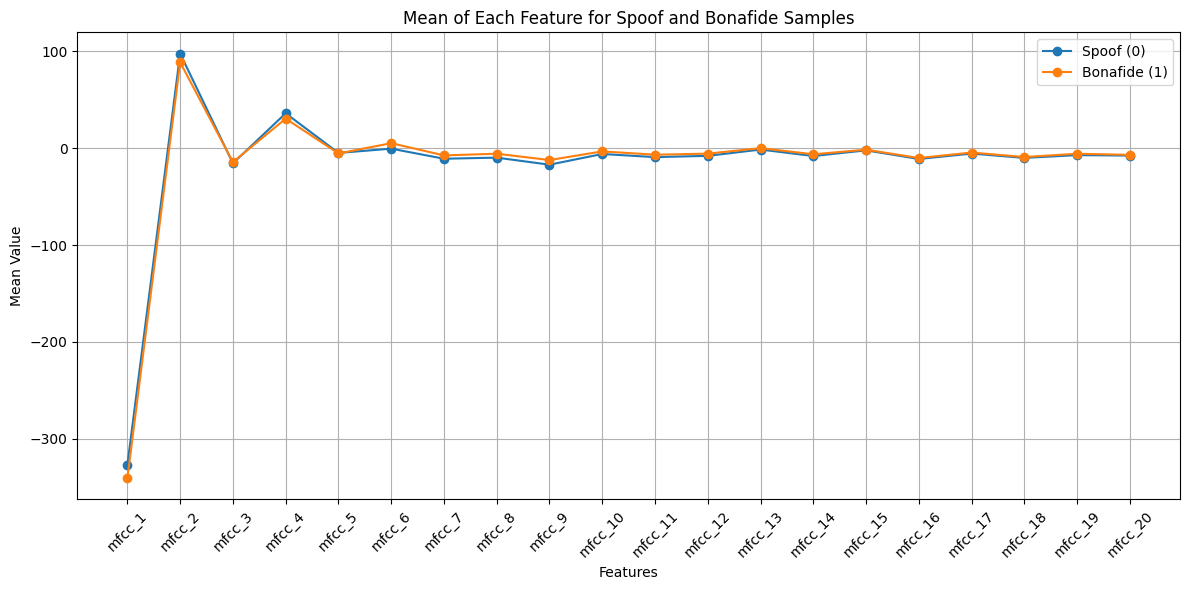

In [ ]:
# Convert all feature columns to numeric, forcing errors to NaN
for col in df_cleaned.columns:
    if col != "Label":
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Calculate mean of each feature for both labels
mean_spoof = df_cleaned[df_cleaned['Label'] == 0].mean()
mean_bonafide = df_cleaned[df_cleaned['Label'] == 1].mean()

# Plot the means
plt.figure(figsize=(12, 6))
plt.plot(mean_spoof.index[1:], mean_spoof.values[1:], label='Spoof (0)', marker='o')
plt.plot(mean_bonafide.index[1:], mean_bonafide.values[1:], label='Bonafide (1)', marker='o')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean of Each Feature for Spoof and Bonafide Samples')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

As seen, the graphs seems to be very close to each other, which means we cannot derive any useful information. Now let's proceed to creating sets of features X and labels Y, then I will split those sets into training and testing sets. 80/20 split. I will also display a graph showing samples, I will use PCA to reduce dimensionality. I will also check class distribution.

In [ ]:
# Drop all rows with NaN values
df_cleaned = df_cleaned.dropna()

# Separate features and labels
X = df_cleaned.drop(columns=["Label"])  # X contains features without columns Label and ID
Y = df_cleaned["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

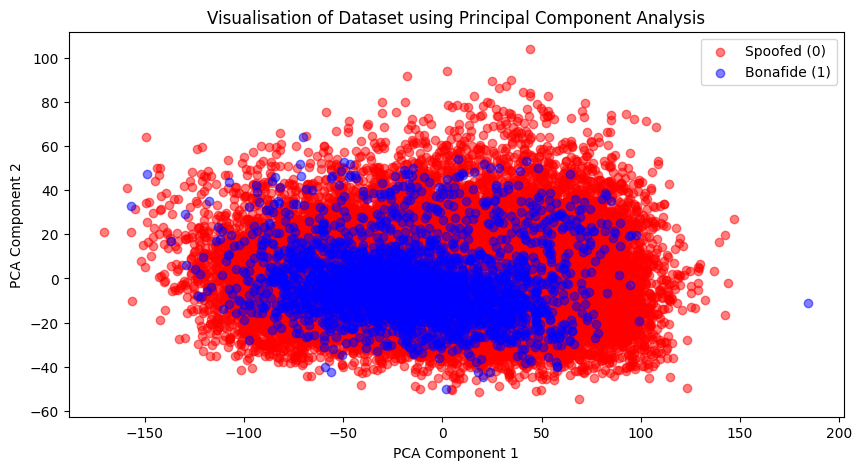

In [ ]:
# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 5))
plt.scatter(X_pca[Y == 0, 0], X_pca[Y == 0, 1], label="Spoofed (0)", alpha=0.5, color="red")
plt.scatter(X_pca[Y == 1, 0], X_pca[Y == 1, 1], label="Bonafide (1)", alpha=0.5, color="blue")
plt.title("Visualisation of Dataset using Principal Component Analysis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [ ]:
# Check class distribution after SMOTE
class_counts = pd.Series(Y).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
0    22800
1     2580
Name: count, dtype: int64


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2141831)

print("Training size (Original):", X_train.shape[0])
print("Test size (Original):", X_test.shape[0])

Training size (Original): 20304
Test size (Original): 5076


Decision Tree Algorithm¶

In this step I will train model using Decision Tree Algorithm, I will calculate metrics (accuracy, precission, recall, f1 score, roc). Then I will try to run the model with different parameters in order to find best Hyperparameters for Decision Tree Alogirthm.

N.B I will train and test the model on non-scaled data, because in algorithms like Decision Forest, Random Forest, data does not have to be scaled, since such algorithm perform splitting on data to find outliers. Such splitting is based only on feature values itself, which are independent from scaling.

In [ ]:
clf = DecisionTreeClassifier(random_state=214831)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
roc_score = roc_auc_score(Y_test, Y_pred)

report = classification_report(Y_test, Y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4598
           1       0.60      0.59      0.60       478

    accuracy                           0.92      5076
   macro avg       0.78      0.78      0.78      5076
weighted avg       0.92      0.92      0.92      5076



Random Forest

In this part I will use Random Forest classifier. As in previous part I will use both datasets and compare the results. Random Forest classifier has more hyperparameters which can be tuned, so i performed some hypertuning of parameters (n_estimators, max_depth) and i ran the classifier with the paramneters that gave better results.


In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=100, random_state=2141831)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Model Accuracy: 0.9574

Confusion Matrix:
 [[4583   15]
 [ 201  277]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4598
           1       0.95      0.58      0.72       478

    accuracy                           0.96      5076
   macro avg       0.95      0.79      0.85      5076
weighted avg       0.96      0.96      0.95      5076



My model can predict if sample is spoofed with very good precision and recall, with bonafide samples, recall is lower, This may be due to a fact, that our dataset is imbalanced, that is it contains more spoofed samples than bonafide. Let's now run this model in a loop with different set of parameters ussing GridSearchCV. This will allow us to select best parameters for model.

In [ ]:
# Define the Random Forest model
rf_gpu = RandomForestClassifier(random_state=2141831)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees
    'max_depth': [10, 20, 30, None],   # Depth of trees
    'min_samples_split': [2, 5, 10],   # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],     # Min samples in a leaf node
    'bootstrap': [True, False]         # Bootstrap sampling
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_gpu,
    param_grid=param_grid,
    cv=5,            # 5-fold cross-validation
    n_jobs=-1,       # Use all processors
    verbose=3
)


# Fit the model
grid_search.fit(X_train, Y_train)

# Get best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model prediction
best_rf_gpu = grid_search.best_estimator_
y_pred_best = best_rf_gpu.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(Y_test, y_pred_best))
print("Classification Report:\n", classification_report(Y_test, y_pred_best))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.9613869188337274
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      4598
           1       0.93      0.64      0.76       478

    accuracy                           0.96      5076
   macro avg       0.95      0.82      0.87      5076
weighted avg       0.96      0.96      0.96      5076



In [ ]:
import joblib

#Save the best model to a file
joblib.dump(grid_search.best_estimator_, 'best_rf_model.pkl')

#To load the model later
loaded_model = joblib.load('best_rf_model.pkl')

#Verify the loaded model
print("Loaded Model Accuracy:", loaded_model.score(X_test, Y_test))

Loaded Model Accuracy: 0.9613869188337274


### Importance of features.

Let's plot importance of features in order to see, whcih features are more important for our model.

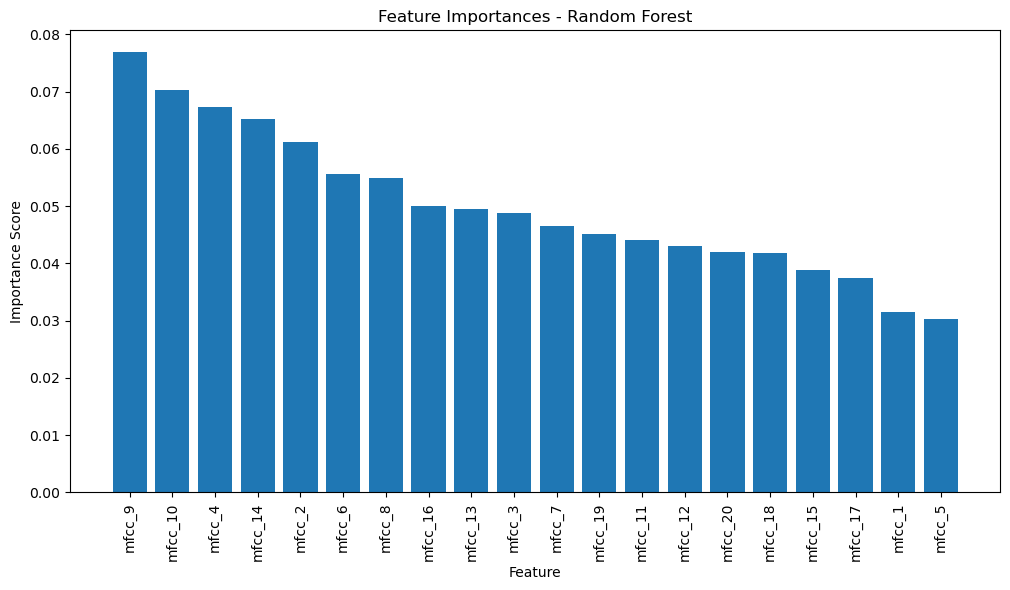

In [ ]:
# Extract feature importance
importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importances after SMOTE
plt.figure(figsize=(12,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

### Extreme Gradient Boosting

In this part I will train the model using XGBoost, note that in this case the features need to be scaled, because it helps model to run faster. While Random Forest trains multiple independent trees, XGBoost uses boosting, where trees are trained sequentially, with each tree correcting errors from the previous one.

Firstly, let's use standard scaler to scale the data.

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 2141831)


Now, initialize XGBoost Classifier with some starting parameters and train the model. In this step we train the model on original data.

In [ ]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,  # Depth of each tree
    learning_rate=0.1,  # Step size shrinkage
    subsample=0.8,  # Percentage of samples used per tree
    colsample_bytree=0.8,  # Percentage of features used per tree
    random_state=2141831
)

xgb_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model performance
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
conf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
class_report_xgb = classification_report(Y_test, Y_pred_xgb)

# Print model evaluation results
print(f"\nXGBoost Model Accuracy: {accuracy_xgb:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)


XGBoost Model Accuracy: 0.9632

Confusion Matrix:
 [[4550   48]
 [ 139  339]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      4598
           1       0.88      0.71      0.78       478

    accuracy                           0.96      5076
   macro avg       0.92      0.85      0.88      5076
weighted avg       0.96      0.96      0.96      5076



XGBoost Model seems to give better results. Let's now run it in a loop for different parameters in order to choose optimal parameters.

In [ ]:
# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [3, 6, 10],  # Depth of each tree
    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "subsample": [0.7, 0.8, 1.0],  # % of samples used per tree
    "colsample_bytree": [0.7, 0.8, 1.0],  # % of features used per tree
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=2141831, use_label_encoder=False, eval_metric='logloss')

# Perform GridSearchCV to find best parameters
grid_search = GridSearchCV(
    estimator=xgb, param_grid=param_grid,
    scoring="accuracy", cv=3, verbose=2, n_jobs=-1
)

# Fit GridSearchCV to training data
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)

# Train the final XGBoost model with the best parameters
best_xgb = XGBClassifier(**best_params, random_state=2141831)
best_xgb.fit(X_train, Y_train)

# Make predictions
Y_pred_best = best_xgb.predict(X_test)

# Evaluate optimized model
accuracy_best = accuracy_score(Y_test, Y_pred)
conf_matrix_best = confusion_matrix(Y_test, Y_pred)
class_report_best = classification_report(Y_test, Y_pred)

# Print model evaluation results
print(f"\nOptimized XGBoost Model Accuracy: {accuracy_best:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_best)
print("\nClassification Report:\n", class_report_best)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\vjesc\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

Optimized XGBoost Model Accuracy: 0.9574

Confusion Matrix:
 [[4583   15]
 [ 201  277]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4598
           1       0.95      0.58      0.72       478

    accuracy                           0.96      5076
   macro avg       0.95      0.79      0.85      5076
weighted avg       0.96      0.96      0.95      5076



### Support Vector Machine

Now let's run SVM algorithm on original dataset, then let's try to find best hyperparameters.



In [ ]:
# Train SVM Classifier with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=2141831)
svm_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_svm = svm_model.predict(X_test)

# Evaluate model performance
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
conf_matrix_svm = confusion_matrix(Y_test, Y_pred_svm)
class_report_svm = classification_report(Y_test, Y_pred_svm)

# Print model evaluation results
print(f"\nSVM Model Accuracy: {accuracy_svm:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_svm)
print("\nClassification Report:\n", class_report_svm)


SVM Model Accuracy: 0.9706

Confusion Matrix:
 [[4547   51]
 [  98  380]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4598
           1       0.88      0.79      0.84       478

    accuracy                           0.97      5076
   macro avg       0.93      0.89      0.91      5076
weighted avg       0.97      0.97      0.97      5076



We've got even better results with Support Vector Machine

### Bernford's Law - Statistics of leading digits

Bernford's Law states that in real-life data, leading digits tend to be small, let's see if this is also the case in our dataset.

C:\Users\vjesc\AppData\Local\Temp\ipykernel_12156\959801104.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
C:\Users\vjesc\AppData\Local\Temp\ipykernel_12156\959801104.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()


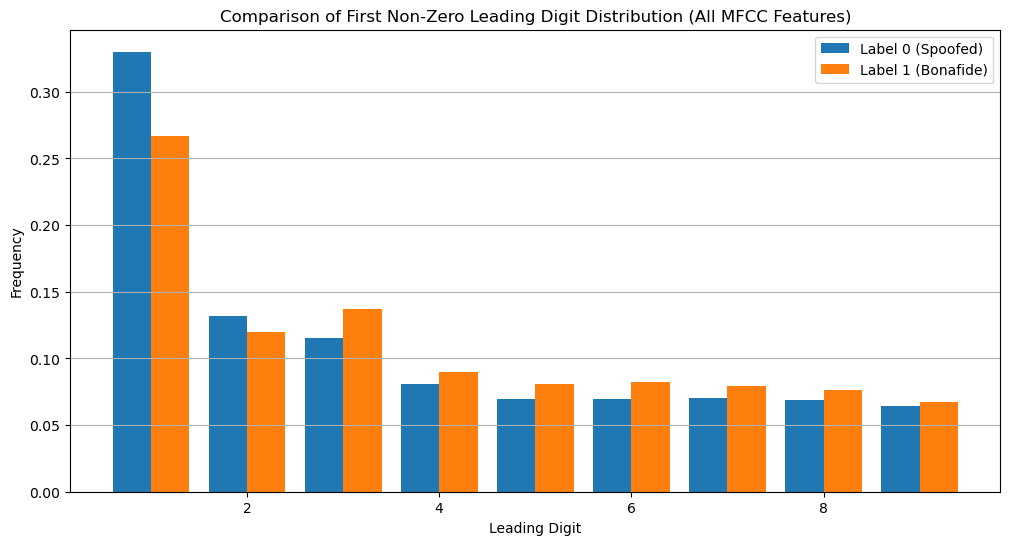

In [ ]:
# Function to extract the first non-zero leading digit from a number
def first_non_zero_leading_digit(x):
    x = abs(float(x))
    if x == 0:
        return 0
    while x < 1:
        x *= 10
    return int(str(int(x)).lstrip('0')[0]) if str(int(x)).lstrip('0') else 0

# Select MFCC columns
mfcc_columns = [col for col in df_cleaned.columns if col.startswith('mfcc_')]

# Filter data for label 0 and label 1
label_0_data = df_cleaned[df_cleaned['Label'] == 0]
label_1_data = df_cleaned[df_cleaned['Label'] == 1]

# Combine all MFCC features into one series of leading digits
all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()

# Calculate frequency distribution of leading digits
combined_leading_digit_stats_label_0 = pd.Series(all_leading_digits_label_0).value_counts(normalize=True).sort_index()
combined_leading_digit_stats_label_1 = pd.Series(all_leading_digits_label_1).value_counts(normalize=True).sort_index()

# Plotting the combined leading digit statistics for both labels
plt.figure(figsize=(12, 6))
plt.bar(combined_leading_digit_stats_label_0.index - 0.2, combined_leading_digit_stats_label_0.values, width=0.4, label='Label 0 (Spoofed)')
plt.bar(combined_leading_digit_stats_label_1.index + 0.2, combined_leading_digit_stats_label_1.values, width=0.4, label='Label 1 (Bonafide)')

plt.title('Comparison of First Non-Zero Leading Digit Distribution (All MFCC Features)')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')
plt.show()
